# Step-by-step MNIST Digits Classification - Simple Fully Connected Neural Network for MNIST Classification - PyTorch

In this example, we will see how to implement a simple fully connected neural network using PyTorch for classifying the digits in the MNIST dataset.

1. Set your data loader, explore your data 

2. Define your model

3. Train your model with the appropriate loss function, optmizer, learning rate, batch_size, checkpoints, etc.

    3.1 If you are satisfied with the train and validation performance go to the next step

    3.2 If you are not satisfied with the train and validation performance go back to step 5

4. Test your model on the test and extract relevant metrics

In [1]:
import torch # pytorch main library 
import torchvision # computer vision utilities
import torchvision.transforms as transforms # transforms used in the pre-processing of the data

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [2]:
# Function to get thge statistics of a dataset
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0] # Get the images to compute the stgatistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean,std

# functions to show an image
def imshow(img,stats):
    img = img *stats[1] + stats[0]     # unnormalize
    npimg = img.numpy() # convert the tensor back to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
batch_size = 256

transform = transforms.Compose(
    [transforms.ToTensor()]) # Convert the data to a PyTorch tensor

# Load develpoment dataset
devset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform = transform)

train_set_size = int(len(devset) * 0.8)
val_set_size = len(devset) - train_set_size

# Split the development set into train and validation
trainset, valset = torch.utils.data.random_split(devset, [train_set_size, val_set_size], generator=torch.Generator().manual_seed(42))


# Get the data loader for the train set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Comopute the statistics of the train set
stats = get_dataset_stats(trainloader)
print("Train stats:", stats)
# Pre-processing transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((stats[0]), (stats[1]))])


# Load the development set again using the proper pre-processing transforms
devset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform = transform)

# Split the development set into train and validation
trainset, valset = torch.utils.data.random_split(devset, [train_set_size, val_set_size], generator=torch.Generator().manual_seed(42))

# Get the data loader for the train set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Get the data loader for the test set
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Get the test set
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

# Get the data loader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

Train stats: (tensor([0.1307]), tensor([0.3016]))


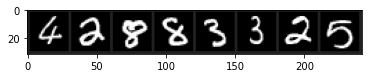

four  two   eight eight three three two   five 


In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]), stats)
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Optimizer used for training

In [7]:
nepochs = 20
PATH = './cifar_net.pth' # Path to save the best model

best_loss = 1e+20
for epoch in range(nepochs):  # loop over the dataset multiple times
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end = ' ')
    
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / i:.3f}')
        
        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
        
print('Finished Training')

1,  train loss: 2.063, val loss: 1.580
Saving model
2,  train loss: 0.971, val loss: 0.657
Saving model
3,  train loss: 0.532, val loss: 0.480
Saving model
4,  train loss: 0.423, val loss: 0.417
Saving model
5,  train loss: 0.374, val loss: 0.380
Saving model
6,  train loss: 0.344, val loss: 0.356
Saving model
7,  train loss: 0.323, val loss: 0.337
Saving model
8,  train loss: 0.306, val loss: 0.324
Saving model
9,  train loss: 0.292, val loss: 0.311
Saving model
10,  train loss: 0.280, val loss: 0.300
Saving model
11,  train loss: 0.269, val loss: 0.290
Saving model
12,  train loss: 0.259, val loss: 0.281
Saving model
13,  train loss: 0.250, val loss: 0.273
Saving model
14,  train loss: 0.242, val loss: 0.265
Saving model
15,  train loss: 0.235, val loss: 0.258
Saving model
16,  train loss: 0.227, val loss: 0.250
Saving model
17,  train loss: 0.221, val loss: 0.244
Saving model
18,  train loss: 0.215, val loss: 0.240
Saving model
19,  train loss: 0.209, val loss: 0.234
Saving model
20

In [8]:
# Load the best model to be used in the test set
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

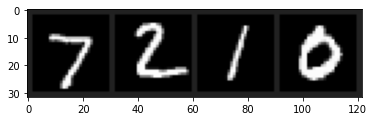

GroundTruth:  seven two   one   zero 


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)


# print images
imshow(torchvision.utils.make_grid(images[:4]), stats)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs = net(images)

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  seven two   one   zero 


In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 94.0 %


In [12]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: zero  is 98.3 %
Accuracy for class: one   is 97.6 %
Accuracy for class: two   is 93.0 %
Accuracy for class: three is 93.5 %
Accuracy for class: four  is 93.7 %
Accuracy for class: five  is 89.8 %
Accuracy for class: six   is 95.7 %
Accuracy for class: seven is 93.4 %
Accuracy for class: eight is 91.0 %
Accuracy for class: nine  is 93.3 %
